In [17]:
# model wrapper
import sys
import os
ROOT_DIR = os.getenv('MB_ROOT_PATH')
sys.path.append(ROOT_DIR)
from models.all_models.model_3L_abs_blurpool_avgpool import ExpansionModel
from models.all_models.alexnet import Alexnet
from tqdm import tqdm
import pickle
from analysis.image_classification.train import *
from analysis.image_classification import config
from tools.processing import *
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tools.processing import *
from plots.performance_plots import *


DATA_DIR = os.getenv('MB_DATA_PATH')
ACTIVATIONS_PATH = os.path.join(DATA_DIR,'activations') 
DATASET, MODE = 'places', None
HOOK = None
MAX_POOL = True

# SVM Classification

In [9]:
def train(features, labels, estimator_type, shuffle = True, num_folds=10):

    
    features = normalize(features)
    splits = create_splits(n = len(features), shuffle = shuffle, num_folds=num_folds)
        
    _y_true, _y_pred, _y_prob = [], [], []
    
    for indices_test in tqdm(splits):
        
        if estimator_type == 'svm':
            classifier = svm.SVC(probability=True)


        if estimator_type == 'logistic':
            classifier = LogisticRegression()
            

        
        indices_train = np.setdiff1d(np.arange(0, len(features)), np.array(indices_test))
        X_train, y_train = features[indices_train,...], labels[indices_train,...]
        X_test, y_test = features[indices_test,...], labels[indices_test,...]
        print(X_train.shape, y_train.shape)
        print(X_test.shape, y_test.shape)
            
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        y_prob = classifier.predict_proba(X_test)
        
        _y_true.append(y_test)
        _y_pred.append(y_pred)
        _y_prob.append(y_prob)
            
    return _y_true, _y_pred, _y_prob 

## expansion model

In [21]:
model_info =   {
                'iden':'expansion_model_final',
                'model':ExpansionModel(filters_3=10000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':3,
                'num_features':10000,
                'max_pool':MAX_POOL,
}
    
activations_identifier = get_activations_iden(model_info, DATASET, MODE)

# get model activations  
activations = Activations(model=model_info['model'],
                        layer_names=model_info['layers'],
                        dataset=DATASET,
                        preprocess=model_info['preprocess'],
                        mode = MODE,
                        _hook = HOOK,
                         batch_size = 50)

activations.get_array(ACTIVATIONS_PATH,activations_identifier) 
data = xr.open_dataset(os.path.join(ACTIVATIONS_PATH,activations_identifier))
data_subset = data.where(data.stimulus_id.isin(val_images_subset),drop=True).x.values
labels_subset = np.array([cat_dict_subset[i] for i in val_images_subset])
    
y_true, y_pred, y_prob = train(features = data_subset, labels = labels_subset, 
                     estimator_type = 'svm', shuffle = True, num_folds=5)

array is already saved in /data/atlas/activations as expansion_model_final_mp_3_layers_10000_features_places


  0%|                                           | 0/5 [00:00<?, ?it/s]

(8000, 256) (8000,)
(2000, 256) (2000,)


 20%|███████                            | 1/5 [01:02<04:08, 62.21s/it]

(8000, 256) (8000,)
(2000, 256) (2000,)


 40%|██████████████                     | 2/5 [02:04<03:06, 62.22s/it]

(8000, 256) (8000,)
(2000, 256) (2000,)


 60%|█████████████████████              | 3/5 [03:06<02:04, 62.30s/it]

(8000, 256) (8000,)
(2000, 256) (2000,)


 80%|████████████████████████████       | 4/5 [04:08<01:02, 62.11s/it]

(8000, 256) (8000,)
(2000, 256) (2000,)


100%|███████████████████████████████████| 5/5 [05:06<00:00, 61.32s/it]


In [22]:
top_1, top_5 = [], [] 

for i in range(len(y_true)):
    top_1.append(top_k(y_true[i], y_prob[i], k=1))
    top_5.append(top_k(y_true[i], y_prob[i], k=5))

print('top_1:',sum(top_1)/len(top_1))
print('top_5:',sum(top_5)/len(top_5))

top_1: 0.09690000000000001
top_5: 0.28659999999999997


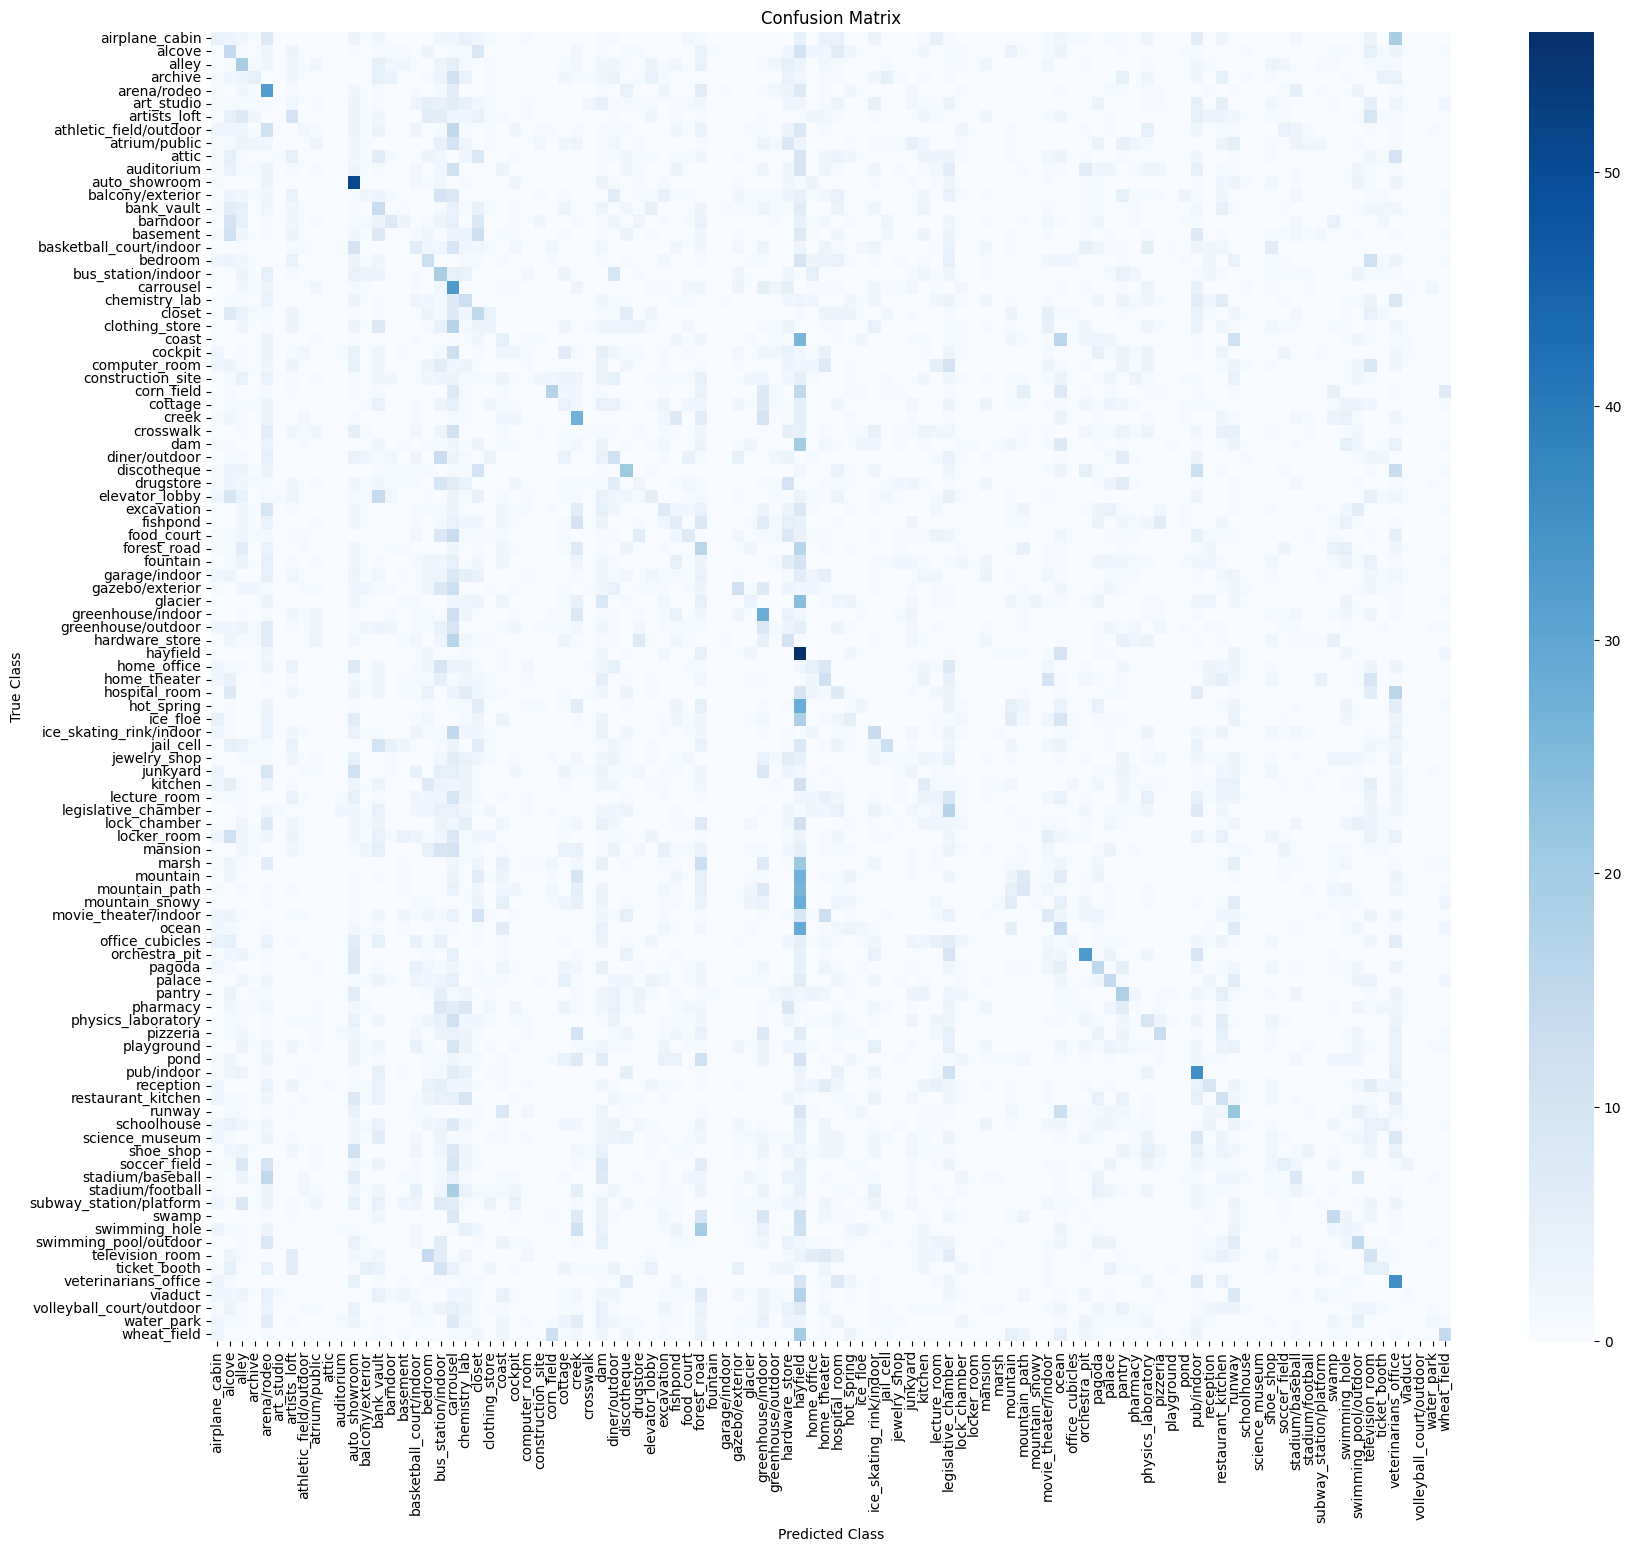

In [34]:
_y_true, _y_pred = [], []

for i in range(5):
    _y_true.extend(y_true[i])
    _y_pred.extend(y_pred[i])   
  
    
cm_expansion = confusion_matrix(_y_true, _y_pred, labels=sorted(cat_subset))
with open('cm_expansion','wb') as f:
    pickle.dump(cm_expansion, f)

class_names = [CAT_NAMES[i] for i in sorted(cat_subset)]

fig = plt.figure(figsize=(20, 17),dpi=100)
sns.heatmap(cm_expansion, annot=False, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.savefig(f'cm_expansion.png', dpi=100)
plt.show()

## Alexnet

In [38]:
model_info =   {
    
                'iden':'alexnet_conv5',
                'model':Alexnet().Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
}
    
activations_identifier = get_activations_iden(model_info, DATASET, MODE)

# get model activations  
activations = Activations(model=model_info['model'],
                        layer_names=model_info['layers'],
                        dataset=DATASET,
                        preprocess=model_info['preprocess'],
                        mode = MODE,
                        _hook = HOOK,
                         batch_size = 50)

activations.get_array(ACTIVATIONS_PATH,activations_identifier) 
data = xr.open_dataset(os.path.join(ACTIVATIONS_PATH,activations_identifier))
data_subset = data.where(data.stimulus_id.isin(val_images_subset),drop=True).x.values
labels_subset = np.array([cat_dict_subset[i] for i in val_images_subset])
    
y_true, y_pred, y_prob = train(features = data_subset, labels = labels_subset, 
                     estimator_type = 'svm', shuffle = True, num_folds=5)

array is already saved in /data/atlas/activations as alexnet_conv5_mp_5_layers_256_features_places


  0%|                                           | 0/5 [00:00<?, ?it/s]

(8000, 256) (8000,)
(2000, 256) (2000,)


 20%|███████                            | 1/5 [01:00<04:00, 60.01s/it]

(8000, 256) (8000,)
(2000, 256) (2000,)


 40%|██████████████                     | 2/5 [01:59<02:59, 59.87s/it]

(8000, 256) (8000,)
(2000, 256) (2000,)


 60%|█████████████████████              | 3/5 [02:59<01:59, 59.82s/it]

(8000, 256) (8000,)
(2000, 256) (2000,)


 80%|████████████████████████████       | 4/5 [03:59<00:59, 59.85s/it]

(8000, 256) (8000,)
(2000, 256) (2000,)


100%|███████████████████████████████████| 5/5 [04:59<00:00, 59.91s/it]


In [39]:
top_1, top_5 = [], [] 

for i in range(len(y_true)):
    top_1.append(top_k(y_true[i], y_prob[i], k=1))
    top_5.append(top_k(y_true[i], y_prob[i], k=5))

print('top_1:',sum(top_1)/len(top_1))
print('top_5:',sum(top_5)/len(top_5))

top_1: 0.39390000000000003
top_5: 0.7235


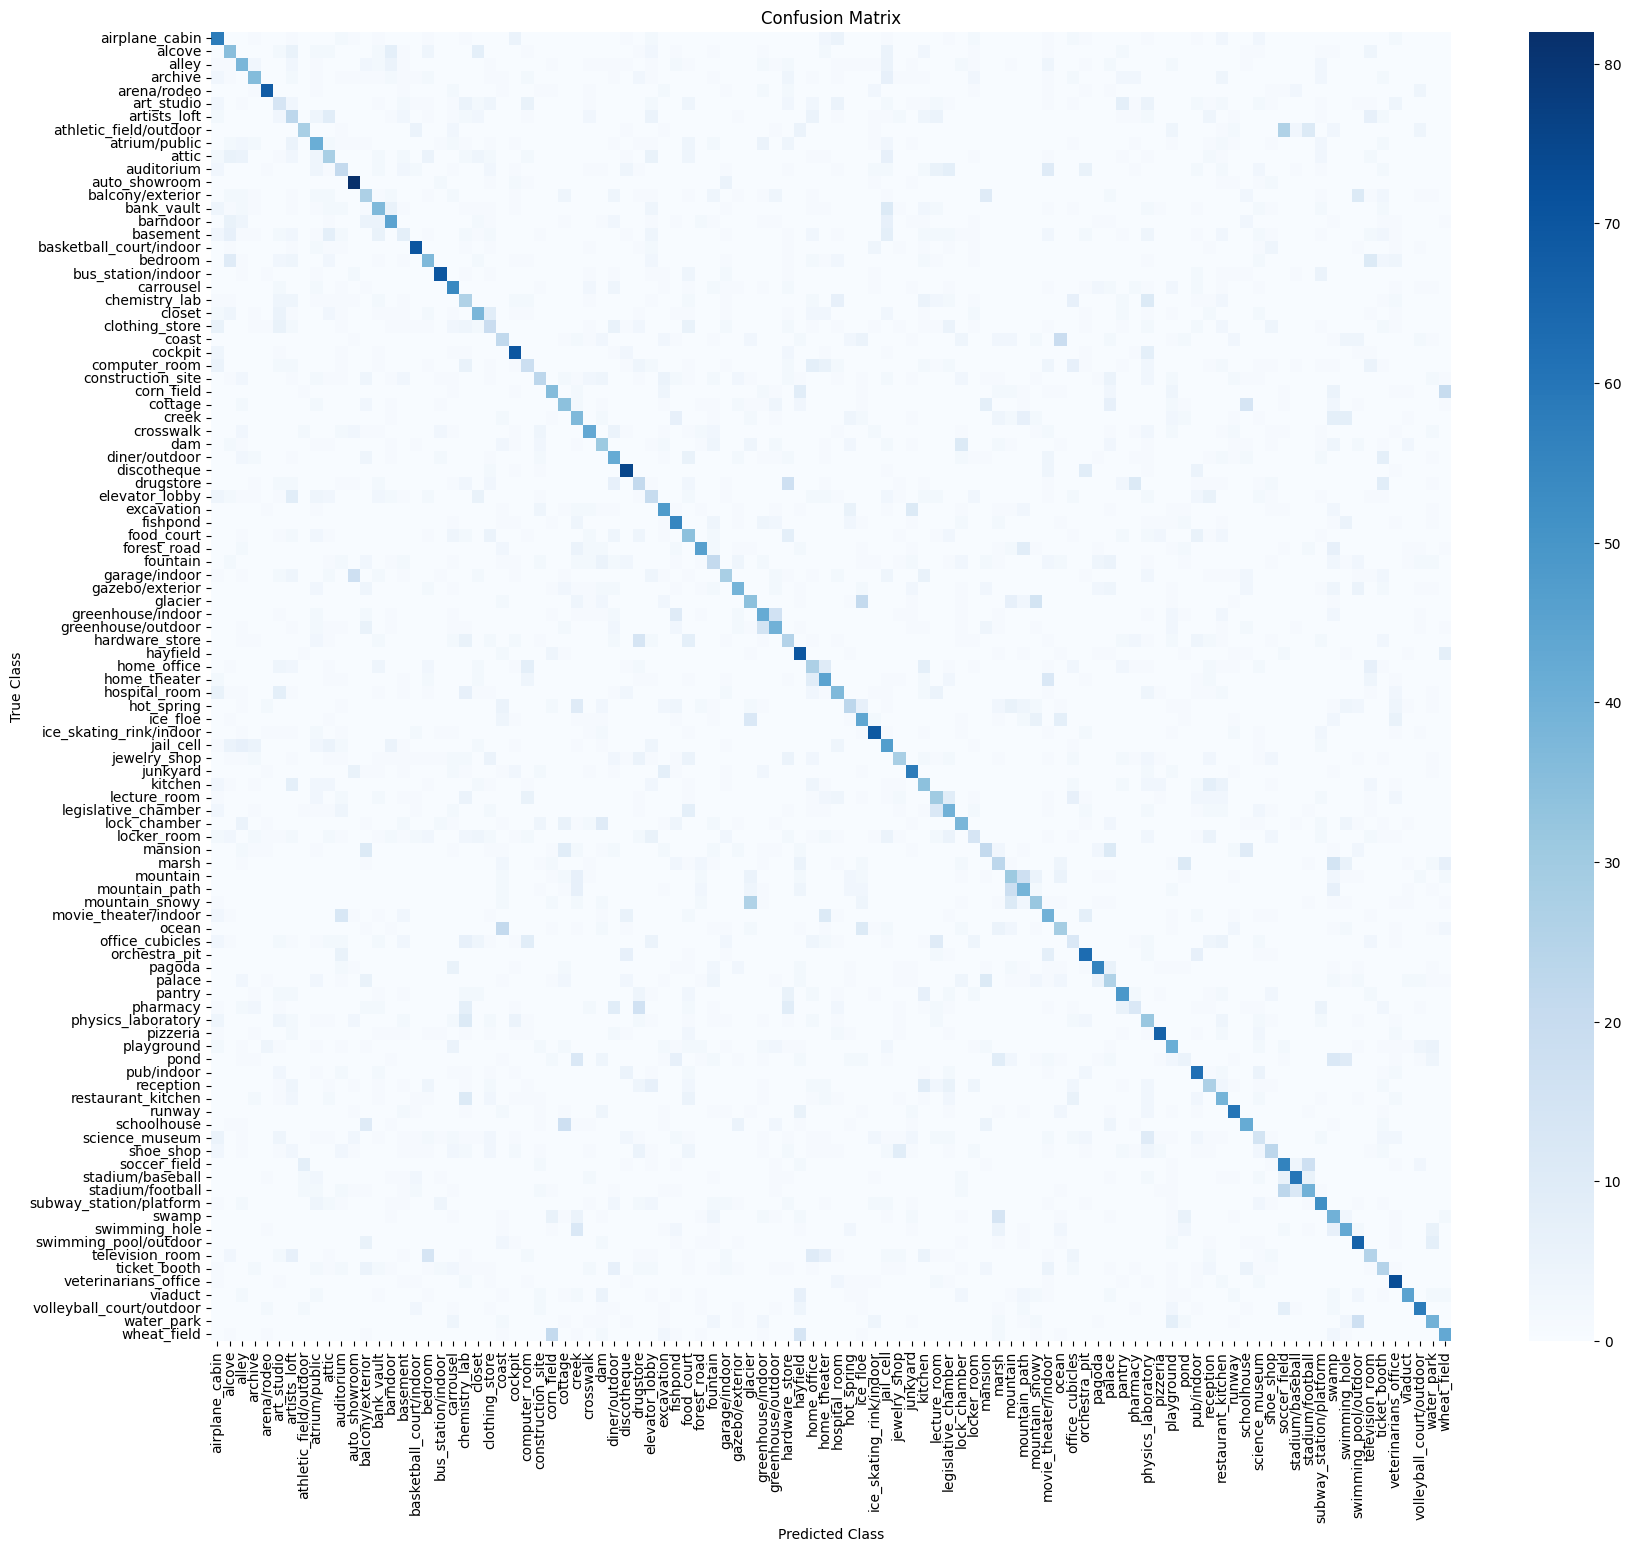

In [40]:
_y_true, _y_pred = [], []

for i in range(5):
    _y_true.extend(y_true[i])
    _y_pred.extend(y_pred[i])   
  
     
cm_alexnet = confusion_matrix(_y_true, _y_pred, labels=sorted(cat_subset))
with open('cm_alexnet','wb') as f:
    pickle.dump(cm_alexnet, f)
    
class_names = [CAT_NAMES[i] for i in sorted(cat_subset)]

fig = plt.figure(figsize=(20, 17),dpi=100)
sns.heatmap(cm_alexnet, annot=False, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

plt.savefig(f'cm_alexnet.png', dpi=100)
plt.show()

## Correlation between confusion matrices

In [45]:
np.corrcoef(cm_expansion.flatten(),cm_alexnet.flatten())

array([[1.        , 0.49175306],
       [0.49175306, 1.        ]])

# Pairwise classification

## expansion model

In [14]:
DATA_DIR = os.getenv('MB_DATA_PATH')
ACTIVATIONS_PATH = os.path.join(DATA_DIR,'activations') 
DATASET, MODE = 'places', None
HOOK = None
MAX_POOL = True



model_info = {
                'iden':'expansion_model_final_original_features_relu',
                'model':ExpansionModel(filters_3=10000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':3,
                'num_features':10000,
                'max_pool':MAX_POOL,
}

activations_identifier = get_activations_iden(model_info, DATASET, MODE)
            
with open(f'/data/atlas/results/image_classification/pairwise_comparison/{activations_identifier}','rb') as f:
    performance_dict = pickle.load(f)

In [15]:
vars = list(set([var for pair in performance_dict.keys() for var in pair]))
var_to_idx = {var: idx for idx, var in enumerate(vars)}
matrix = np.zeros((len(vars), len(vars)))


for (var1, var2), corr in performance_dict.items():
    matrix[var_to_idx[var1], var_to_idx[var2]] = corr
    matrix[var_to_idx[var2], var_to_idx[var1]] = corr  # if the correlation matrix is symmetric
    

rows, cols = np.triu_indices(matrix.shape[0],k=1)
matrix_expansion = matrix[rows, cols]

print('mean:',matrix_expansion.mean())

mean: 0.7236545454545454


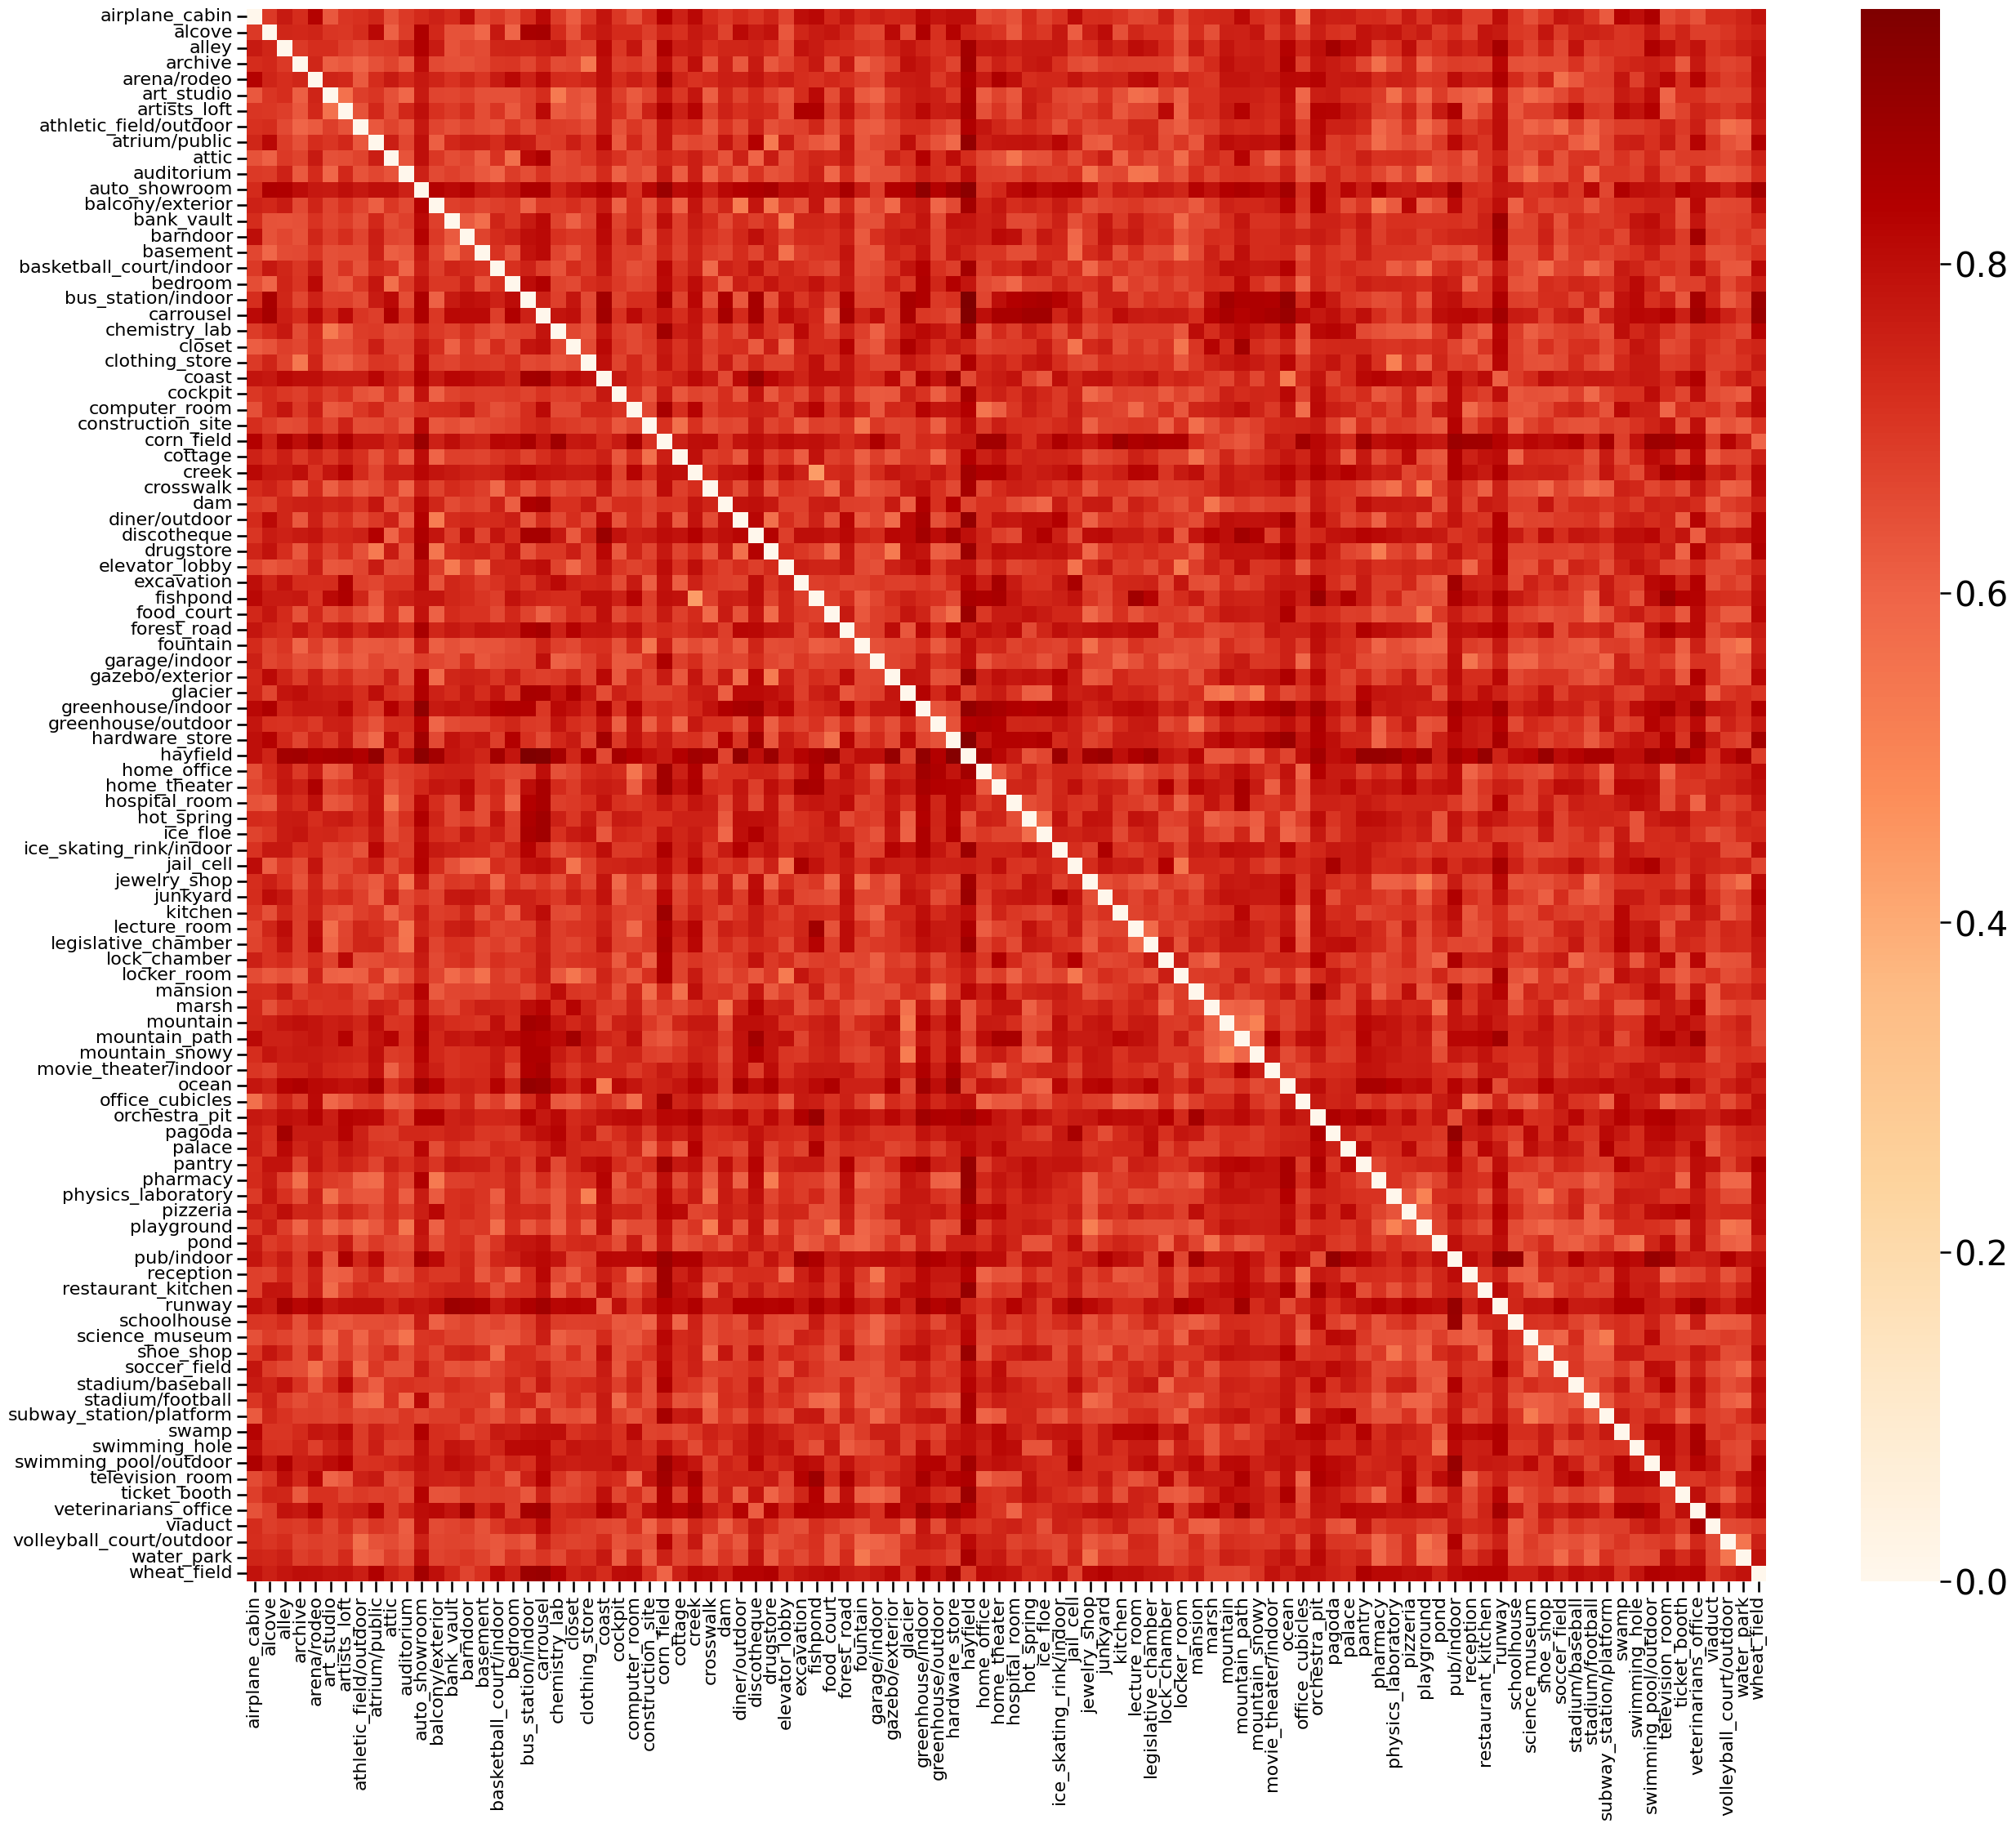

In [16]:
with open(os.path.join('/data/atlas/datasets/places/categories_places365.txt'), "r") as file:
    content = file.read()
annotations = content.split('\n')
cat_names = {}
for i in annotations:
    name_number = i[3:].split(' ')
    cat_names[int(name_number[1])] = name_number[0]
    
    
    
    
class_names = [cat_names[i] for i in vars]
fig = plt.figure(figsize=(30, 25),dpi=100)
heatmap = sns.heatmap(matrix, annot=False, fmt="d", cmap='OrRd', xticklabels=class_names, yticklabels=class_names)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)
plt.savefig(f'pairwise_comparison_expansion.png', dpi=100)
plt.show()

## Alexnet

In [6]:
DATA_DIR = os.getenv('MB_DATA_PATH')
ACTIVATIONS_PATH = os.path.join(DATA_DIR,'activations') 
DATASET, MODE = 'places', None
HOOK = None
MAX_POOL = True


model_info = {   
                'iden':'alexnet_conv5',
                'model':Alexnet().Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
}
activations_identifier = get_activations_iden(model_info, DATASET, MODE)
            
with open(f'/data/atlas/results/image_classification/pairwise_comparison/{activations_identifier}','rb') as f:
    performance_dict = pickle.load(f)

In [7]:
vars = list(set([var for pair in performance_dict.keys() for var in pair]))
var_to_idx = {var: idx for idx, var in enumerate(vars)}
matrix = np.zeros((len(vars), len(vars)))


for (var1, var2), corr in performance_dict.items():
    matrix[var_to_idx[var1], var_to_idx[var2]] = corr
    matrix[var_to_idx[var2], var_to_idx[var1]] = corr  # if the correlation matrix is symmetric
    

rows, cols = np.triu_indices(matrix.shape[0],k=1)
matrix_alexnet = matrix[rows, cols]

print('mean:',matrix_alexnet.mean())

mean: 0.9208363636363637


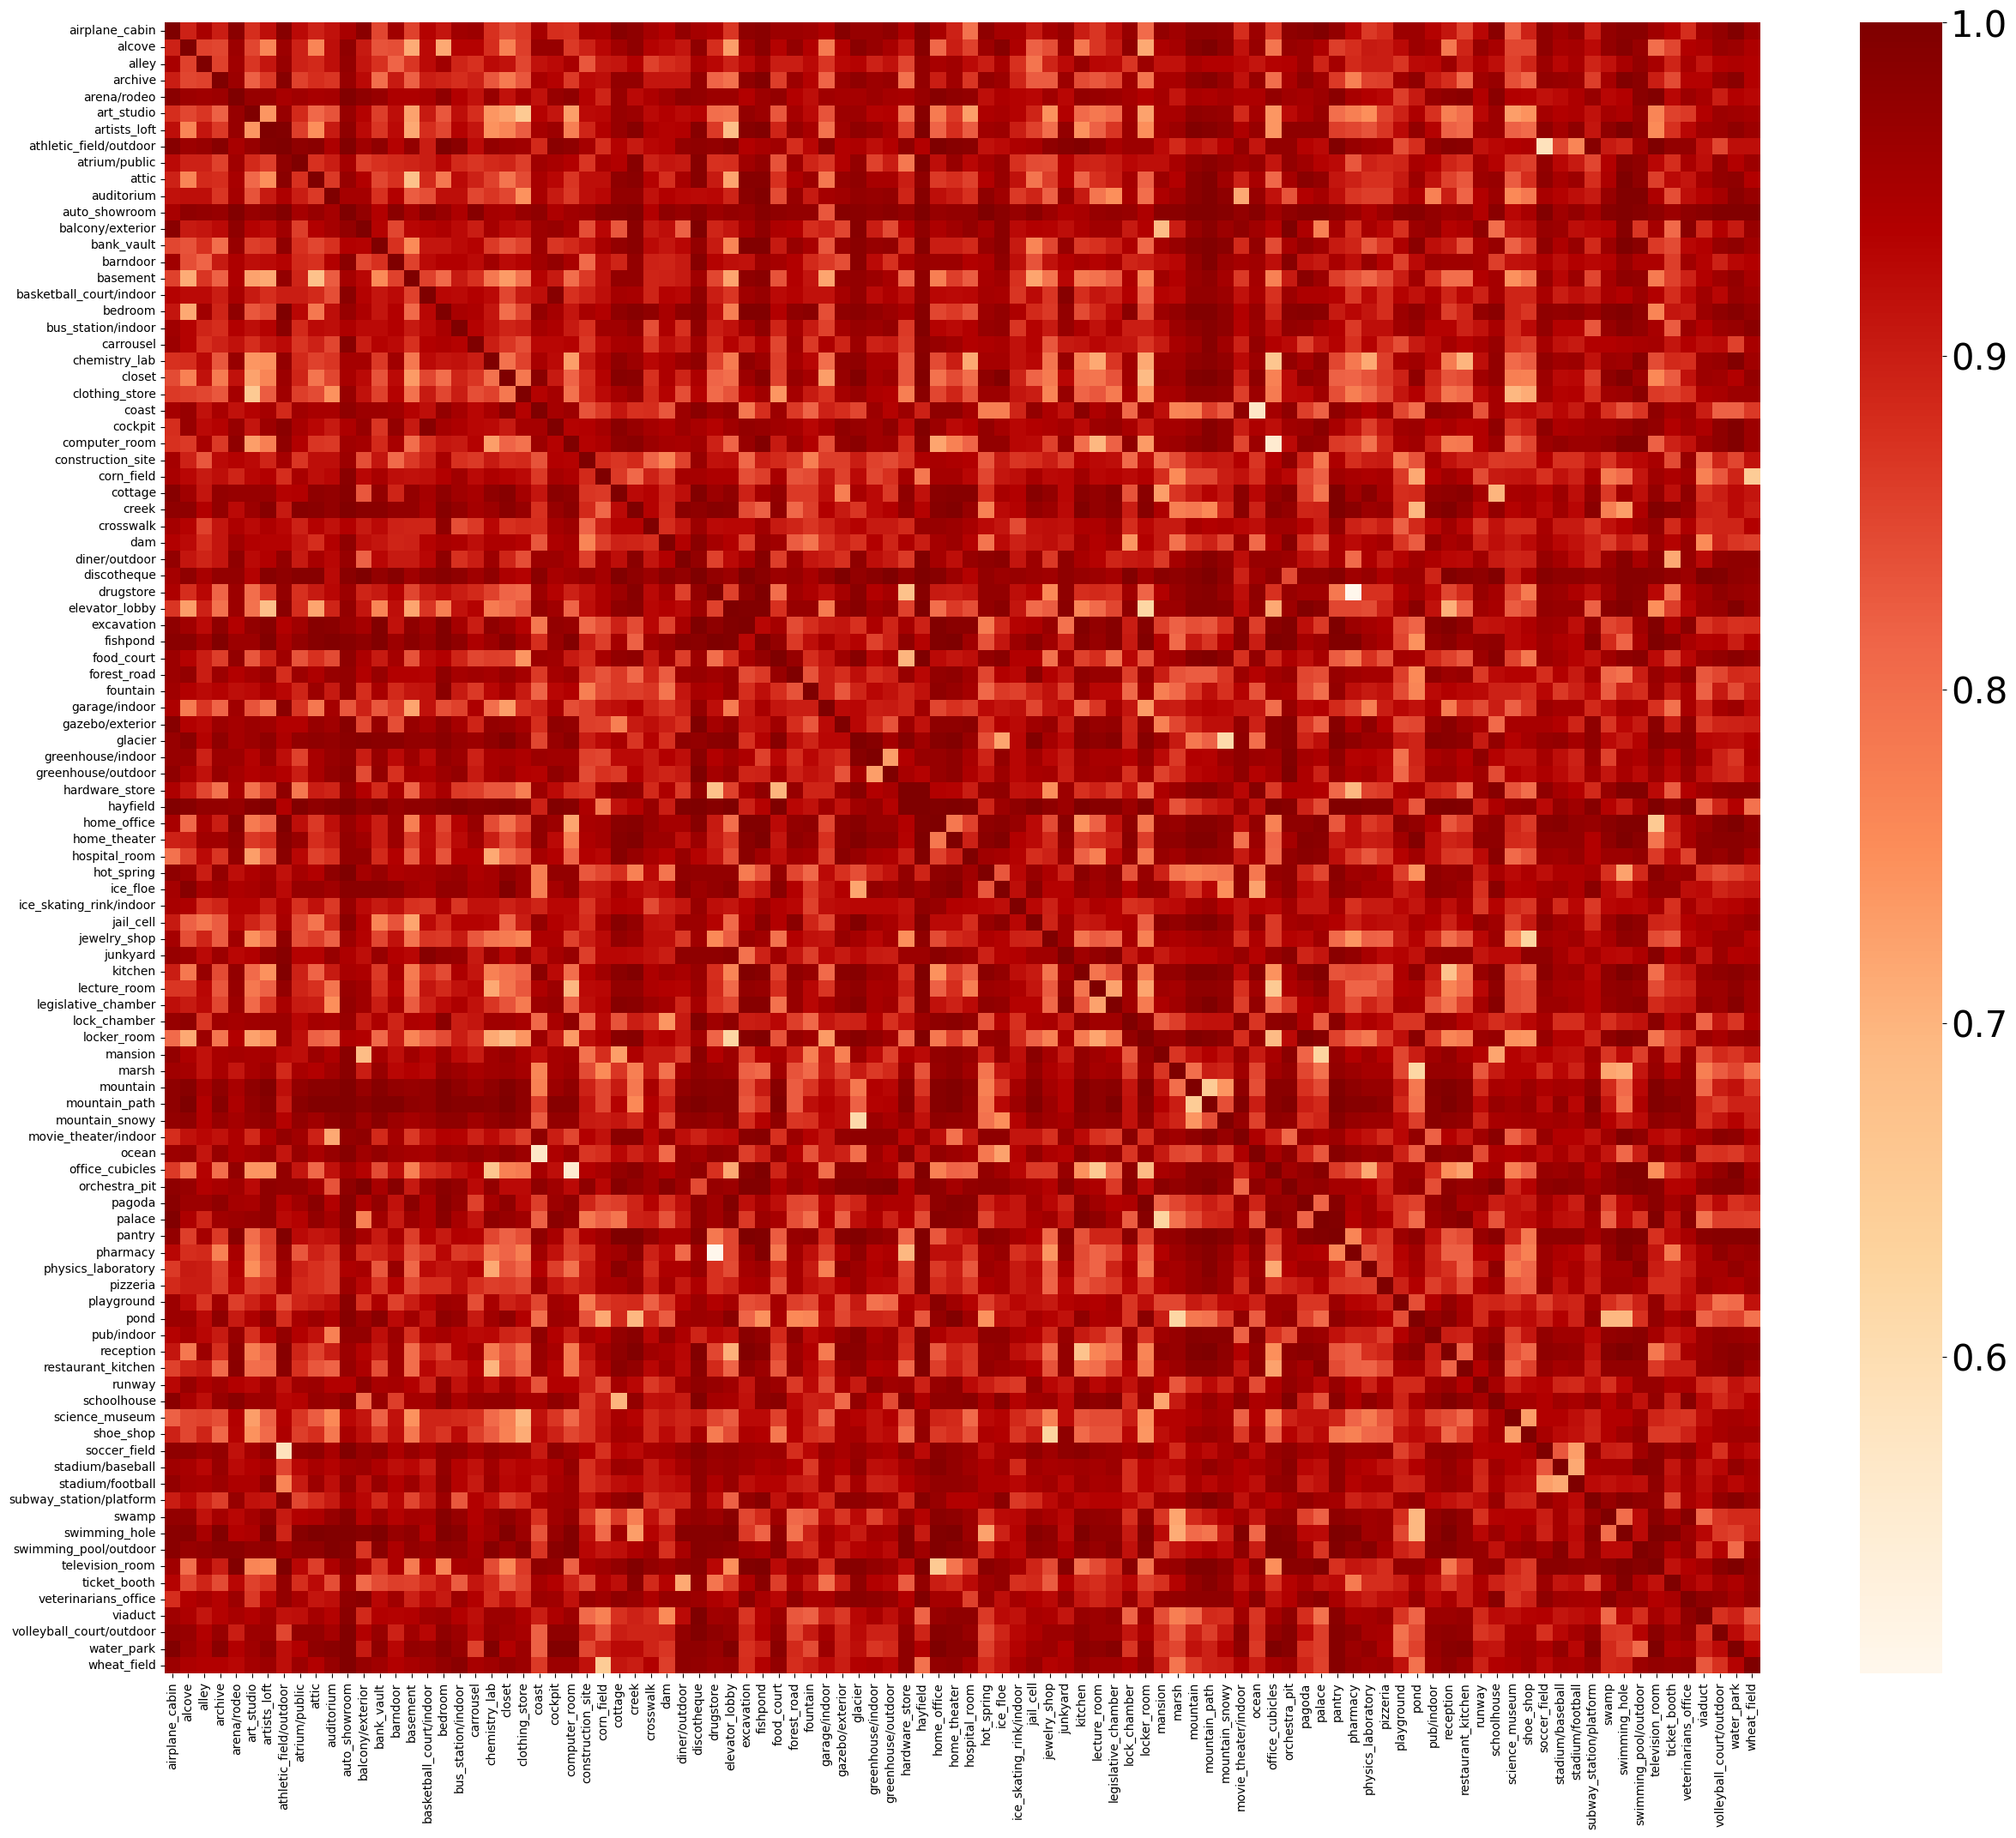

In [8]:
with open(os.path.join('/data/atlas/datasets/places/categories_places365.txt'), "r") as file:
    content = file.read()
annotations = content.split('\n')
cat_names = {}
for i in annotations:
    name_number = i[3:].split(' ')
    cat_names[int(name_number[1])] = name_number[0]
    
    
    
    
class_names = [cat_names[i] for i in vars]
fig = plt.figure(figsize=(30, 25),dpi=100)
heatmap = sns.heatmap(matrix, annot=False, fmt="d", cmap='OrRd', xticklabels=class_names, yticklabels=class_names)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)
plt.savefig(f'pairwise_comparison_alexnet.png', dpi=100)
plt.show()

## Bar Graph

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


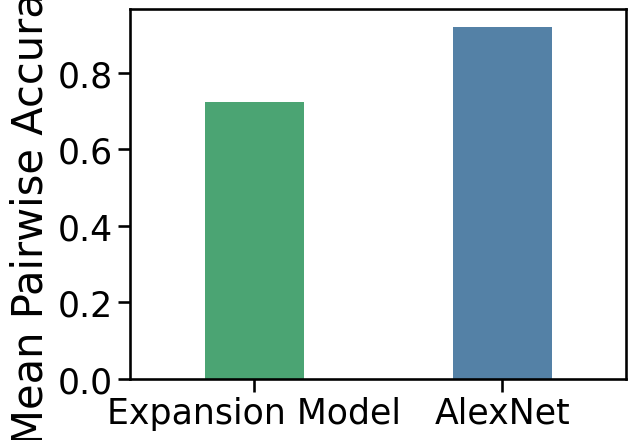

In [9]:
palette = {         
    'Expansion Model':'mediumseagreen',
    'AlexNet':'steelblue'
}


plt.clf()
sns.set_context(context='talk')    
rcParams['figure.figsize'] = (7,8)


ax1 = sns.barplot(x = ['Expansion Model','AlexNet'], 
                  y = [matrix_expansion.mean(), 
                       matrix_alexnet.mean()], 
                  palette=palette,
                       width=0.4, 
                       dodge=False)            
    
ax1.legend().remove()
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.xlabel('')
plt.ylabel(size=30, ylabel='Mean Pairwise Accuracy')    
plt.xticks(size=25)
plt.yticks(size=25)
#plt.title(title, fontsize=25)
plt.savefig('expansion_vs_alexnet.png', bbox_inches='tight', dpi=300)

## Correlation between the pairwise matrices

In [10]:
np.corrcoef(matrix_expansion,matrix_alexnet)

array([[1.        , 0.50709022],
       [0.50709022, 1.        ]])